In [22]:
import pandas as pd
from ta.trend import EMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi

def AddIndicators(df):
    df["ema5"] = EMAIndicator(close=df["close"], window=5, fillna=True).ema_indicator()
    df["ema8"] = EMAIndicator(close=df["close"], window=8, fillna=True).ema_indicator()
    df["ema13"] = EMAIndicator(close=df["close"], window=13, fillna=True).ema_indicator()

    df["MACD"] = macd(close=df["close"], window_slow=26, window_fast=12, fillna=True)

    df["RSI"] = rsi(close=df["close"], window=14, fillna=True)
    
    return df

In [34]:
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)

    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        plt.style.use('ggplot')
        plt.close('all')
        self.fig = plt.figure(figsize=(16,8)) 

        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        self.ax3 = self.ax1.twinx()

        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')

        plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        self.ax4 = self.ax2.twinx()
        self.ema5 = deque(maxlen=self.Render_range)
        self.ema8 = deque(maxlen=self.Render_range)
        self.ema13 = deque(maxlen=self.Render_range)
        self.MACD = deque(maxlen=self.Render_range)
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):
        self.ema5.append(df["ema5"])
        self.ema8.append(df["ema8"])
        self.ema13.append(df["ema13"])

        self.MACD.append(df["MACD"]*100)
        self.RSI.append(df["RSI"])

        self.ax4.clear()
        self.ax4.plot(Date_Render_range, self.MACD,'r-')

        self.ax4.plot(Date_Render_range, self.RSI,'g-')

    def render(self, df, net_worth, trades):
        Date = df["datetime"]
        Open = df["open"]
        High = df["high"]
        Low = df["low"]
        Close = df["close"]
        Volume = df["volume"]
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum

        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['datetime'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['low'] - RANGE*0.02
                    ycoords = trade['low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['high'] + RANGE*0.02
                    ycoords = trade['high'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        self.fig.tight_layout()

        self.fig.canvas.draw()
        
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        cv2.imshow("trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    df["datetime"] = pd.to_datetime(df.Date)
    df["datetime"] = df["datetime"].apply(mpl_dates.date2num)

    df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    
    plt.style.use('ggplot')
    
    fig = plt.figure(figsize=(16,8)) 

    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)

    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('Price', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    
    ax1.plot(df["datetime"], df_original['ema5'],'-')
    ax1.plot(df["datetime"], df_original['ema8'],'-')
    ax1.plot(df["datetime"], df_original['ema13'],'-')

    ax2.plot(df["datetime"], df_original['MACD']*100,'-')

    ax2.plot(df["datetime"], df_original['RSI'],'-')

    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten(input_shape=input_shape)(X_input)
        X = Dense(512, activation="relu")(X)
        X = Dense(256, activation="relu")(X)
        X = Dense(64, activation="relu")(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)

        V = Flatten(input_shape=input_shape)(X_input)
        V = Dense(512, activation="relu")(V)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2)
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [25]:
import os
import copy
import pandas as pd
import numpy as np
import random
from collections import deque
from tensorboardX import SummaryWriter
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
import matplotlib.pyplot as plt
from datetime import datetime

class CustomAgent:
    def __init__(self, lookback_window_size=50, lr=0.00005, epochs=1, optimizer=Adam, batch_size=32, model=""):
        self.lookback_window_size = lookback_window_size
        self.model = model
        
        self.action_space = np.array([0, 1, 2])

        self.log_name = datetime.now().strftime("%Y_%m_%d_%H_%M")+"_trader"
        
        self.state_size = (lookback_window_size, 15)

        self.lr = lr
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size

        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        
    def create_writer(self, initial_balance, normalize_value, train_episodes):
        self.replay_count = 0
        self.writer = SummaryWriter('runs/'+self.log_name)

        if not os.path.exists(self.log_name):
            os.makedirs(self.log_name)

        self.start_training_log(initial_balance, normalize_value, train_episodes)
            
    def start_training_log(self, initial_balance, normalize_value, train_episodes):
        with open(self.log_name+"/Parameters.txt", "w") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training start: {current_date}\n")
            params.write(f"initial_balance: {initial_balance}\n")
            params.write(f"training episodes: {train_episodes}\n")
            params.write(f"lookback_window_size: {self.lookback_window_size}\n")
            params.write(f"lr: {self.lr}\n")
            params.write(f"epochs: {self.epochs}\n")
            params.write(f"batch size: {self.batch_size}\n")
            params.write(f"normalize_value: {normalize_value}\n")
            params.write(f"model: {self.model}\n")
            
    def end_training_log(self):
        with open(self.log_name+"/Parameters.txt", "a+") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training end: {current_date}\n")

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        values = self.Critic.critic_predict(states)
        next_values = self.Critic.critic_predict(next_states)
        
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        y_true = np.hstack([advantages, predictions, actions])
        
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1

        return np.sum(a_loss.history['loss']), np.sum(c_loss.history['loss'])

    def act(self, state):
        prediction = self.Actor.actor_predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=prediction)
        return action, prediction
        
    def save(self, name="trader", score="", args=[]):
        self.Actor.Actor.save_weights(f"{self.log_name}/{score}_{name}_Actor.h5")
        self.Critic.Critic.save_weights(f"{self.log_name}/{score}_{name}_Critic.h5")

        if len(args) > 0:
            with open(f"{self.log_name}/log.txt", "a+") as log:
                current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                atgumets = ""
                for arg in args:
                    atgumets += f", {arg}"
                log.write(f"{current_time}{atgumets}\n")

    def load(self, folder, name):
        self.Actor.Actor.load_weights(os.path.join(folder, f"{name}_Actor.h5"))
        self.Critic.Critic.load_weights(os.path.join(folder, f"{name}_Critic.h5"))

        
class CustomEnv:
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, Render_range=100, Show_reward=False, Show_indicators=False, normalize_value=40000):
        self.df = df.dropna().reset_index()
        self.df_graph = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        self.market_history = deque(maxlen=self.lookback_window_size)

        self.indicators_history = deque(maxlen=self.lookback_window_size)

        self.normalize_value = normalize_value

    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range, Show_reward=self.Show_reward, Show_indicators=self.Show_indicators) # init visualization
        self.trades = deque(maxlen=self.Render_range)
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.held = 0
        self.sold = 0
        self.bought = 0
        self.episode_orders = 0
        self.prev_episode_orders = 0
        self.rewards = deque(maxlen=self.Render_range)
        self.env_steps_size = env_steps_size
        self.punish_value = 0
        if env_steps_size > 0:
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else:
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'volume'],
                                        ])

            self.indicators_history.append([
                                        self.df.loc[current_step, 'ema5'] / self.normalize_value,
                                        self.df.loc[current_step, 'ema8'] / self.normalize_value,
                                        self.df.loc[current_step, 'ema13'] / self.normalize_value,
                                        self.df.loc[current_step, 'MACD'],
                                        self.df.loc[current_step, 'RSI'] / 100
                                        ])
            

        state = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        state = np.concatenate((state, self.indicators_history), axis=1)

        return state

    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume'],
                                    ])

        self.indicators_history.append([self.df.loc[self.current_step, 'ema8'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'ema8'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'ema13'] / self.normalize_value,
                                    self.df.loc[self.current_step, 'MACD'],
                                    self.df.loc[self.current_step, 'RSI'] / 100
                                    ])
        
        obs = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        obs = np.concatenate((obs, self.indicators_history), axis=1)
        
        return obs

    def step(self, action):
        self.bought = 0
        self.sold = 0
        self.current_step += 1

        current_price = self.df.loc[self.current_step, 'open']
        Date = self.df.loc[self.current_step, 'datetime']
        High = self.df.loc[self.current_step, 'high']
        Low = self.df.loc[self.current_step, 'low']

        if action == 0:
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            self.bought = self.balance / current_price
            self.balance -= self.bought * current_price
            self.held += self.bought
            self.trades.append({'datetime' : Date, 'high' : High, 'low' : Low, 'total': self.bought, 'type': "buy", 'current_price': current_price})
            self.episode_orders += 1

        elif action == 2 and self.held>0:
            self.sold = self.held
            self.balance += self.sold * current_price
            self.held -= self.sold
            self.trades.append({'datetime' : Date, 'high' : High, 'low' : Low, 'total': self.sold, 'type': "sell", 'current_price': current_price})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

        reward = self.get_reward()

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    def get_reward(self):
        self.punish_value += self.net_worth * 0.00001
        if self.episode_orders > 1 and self.episode_orders > self.prev_episode_orders:
            self.prev_episode_orders = self.episode_orders
            if self.trades[-1]['type'] == "buy" and self.trades[-2]['type'] == "sell":
                reward = self.trades[-2]['total']*self.trades[-2]['current_price'] - self.trades[-2]['total']*self.trades[-1]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
            elif self.trades[-1]['type'] == "sell" and self.trades[-2]['type'] == "buy":
                reward = self.trades[-1]['total']*self.trades[-1]['current_price'] - self.trades[-2]['total']*self.trades[-2]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
        else:
            return 0 - self.punish_value

    def render(self, visualize = False):
        if visualize:
            img = self.visualization.render(self.df.loc[self.current_step], self.net_worth, self.trades)
            return img

def train_agent(env, agent, visualize=False, train_episodes = 50, training_batch_size=500):
    agent.create_writer(env.initial_balance, env.normalize_value, train_episodes)
    total_average = deque(maxlen=100)
    best_average = 0
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = agent.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state

        a_loss, c_loss = agent.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        agent.writer.add_scalar('Data/average net_worth', average, episode)
        agent.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("episode: {:<5} net worth {:<7.2f} average: {:<7.2f} orders: {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                agent.save(score="{:.2f}".format(best_average), args=[episode, average, env.episode_orders, a_loss, c_loss])
            agent.save()
            
    agent.end_training_log()
    
def test_agent(env, agent, visualize=True, test_episodes=10, folder="", name="_trader", comment=""):
    agent.load(folder, name)
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = agent.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1
                print("episode: {:<5}, net_worth: {:<7.2f}, average_net_worth: {:<7.2f}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break
            
    print("average {} episodes agent net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    print("No profit episodes: {}".format(no_profit_episodes))
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, model: {agent.model}, comment: {comment}\n')




In [26]:
ddf = pd.read_csv('pfedata.csv')[['datetime','open','high','low','close','volume','ema5','ema8','ema13','MACD','RSI']]

In [27]:
ddf 

,datetime,open,high,low,close,volume,ema5,ema8,ema13,MACD,RSI
0,2020-01-02 17:30:00,37.235397,37.292274,36.875177,36.988931,264176.0,36.988931,36.988931,36.988931,0.000000,100.000000
1,2020-01-02 18:30:00,36.988931,37.050548,36.894136,36.936794,113237.0,36.971552,36.977345,36.981483,-0.004159,0.000000
2,2020-01-02 19:30:00,36.932054,36.951013,36.894136,36.946273,75932.0,36.963126,36.970440,36.976453,-0.006614,16.373612
3,2020-01-02 20:30:00,36.946273,36.951013,36.884657,36.894136,48912.0,36.940129,36.953484,36.964693,-0.012621,8.312035
4,2020-01-02 21:30:00,36.903616,36.913095,36.860958,36.879917,55462.0,36.920058,36.937135,36.952582,-0.018318,7.261924
...,...,...,...,...,...,...,...,...,...,...,...
5850,2023-04-28 20:30:00,38.865000,38.880000,38.700000,38.770000,302146.0,38.773945,38.743905,38.747369,-0.194387,43.459267
5851,2023-04-28 21:30:00,38.770000,38.800000,38.705000,38.760000,212364.0,38.769297,38.747481,38.749173,-0.178510,43.152600
5852,2023-04-28 22:30:00,38.760000,38.910000,38.710000,38.900000,492133.0,38.812865,38.781374,38.770720,-0.152869,48.618985
5853,2023-05-01 16:30:00,39.010000,39.200000,38.870000,39.140000,496579.0,38.921910,38.861069,38.823474,-0.111892,56.365215


In [11]:
load_ext tensorboard

In [16]:
reload_ext tensorboard

In [17]:
tensorboard --logdir=runs/ --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 14256), started 1 day, 3:46:05 ago. (Use '!kill 14256' to kill it.)

In [28]:
lookback_window_size = 50
test_window = 805
train_df = ddf[:-test_window-lookback_window_size]
test_df = ddf[-test_window-lookback_window_size:]
agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")

C:\Users\ThinkPadX4\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
test_df['datetime'] = pd.date_range(start = "2022-11-21 18:30:00", periods = 855, freq='H')

C:\Users\ThinkPadX4\AppData\Local\Temp\ipykernel_7516\1364660045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['datetime'] = pd.date_range(start = "2022-11-21 18:30:00", periods = 855, freq='H')


In [30]:
test_df = test_df.iloc[:350]

In [31]:
test_df

,datetime,open,high,low,close,volume,ema5,ema8,ema13,MACD,RSI
5000,2022-11-21 18:30:00,48.010,48.080,47.855,48.010,164095.0,47.874715,47.732564,47.535662,0.456151,67.239274
5001,2022-11-21 19:30:00,47.810,48.090,47.220,47.310,173494.0,47.686477,47.638661,47.503425,0.401467,53.323618
5002,2022-11-21 20:30:00,47.320,47.445,47.195,47.350,95036.0,47.574318,47.574514,47.481507,0.357240,53.910604
5003,2022-11-21 21:30:00,47.340,47.410,47.045,47.045,50356.0,47.397878,47.456844,47.419149,0.294187,48.864575
5004,2022-11-21 22:30:00,47.045,47.270,46.960,47.230,75199.0,47.341919,47.406434,47.392127,0.256192,51.810902
...,...,...,...,...,...,...,...,...,...,...,...
5345,2022-12-06 03:30:00,48.010,48.010,47.860,47.910,44387.0,47.869966,47.782080,47.717245,-0.193203,49.365265
5346,2022-12-06 04:30:00,47.910,48.025,47.850,47.890,47858.0,47.876644,47.806062,47.741924,-0.165421,48.941638
5347,2022-12-06 05:30:00,47.885,48.020,47.800,47.870,127696.0,47.874430,47.820270,47.760221,-0.143365,48.493482
5348,2022-12-06 06:30:00,47.865,47.980,47.805,47.850,95091.0,47.866286,47.826877,47.773046,-0.126046,48.019941


C:\Users\ThinkPadX4\anaconda3\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 0     net worth 955.37  average: 955.37  orders: 38


KeyboardInterrupt: 

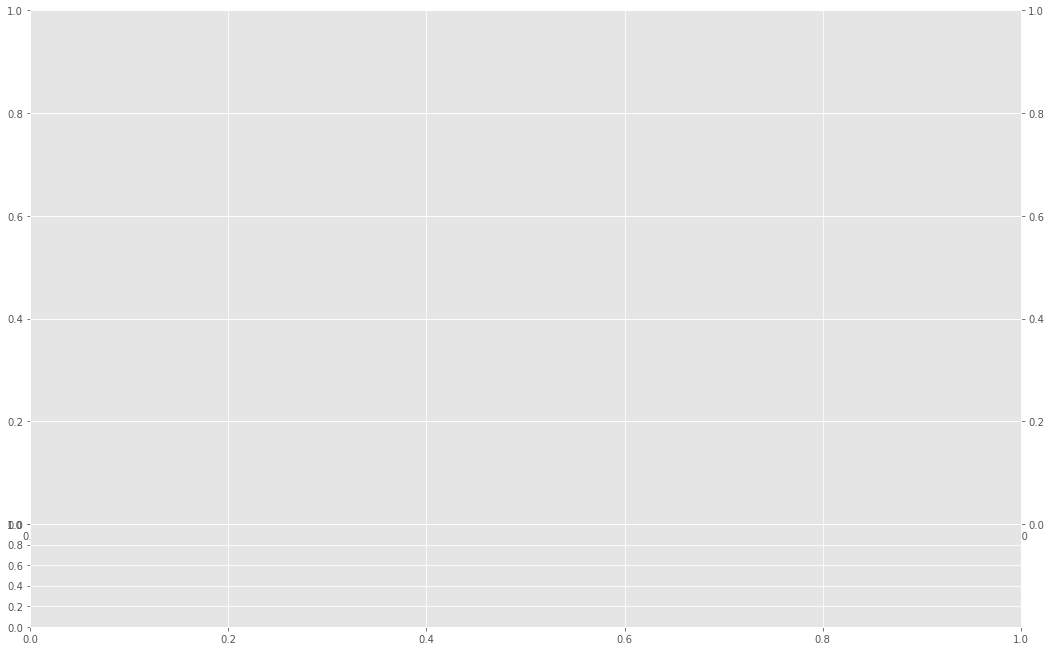

In [20]:
train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size)
train_agent(train_env, agent, visualize=False, train_episodes=20000, training_batch_size=500)

episode: 0    , net_worth: 947.97 , average_net_worth: 947.97 , orders: 122
episode: 1    , net_worth: 977.68 , average_net_worth: 962.83 , orders: 134
episode: 2    , net_worth: 970.04 , average_net_worth: 965.23 , orders: 126
episode: 3    , net_worth: 1003.72, average_net_worth: 974.85 , orders: 132
episode: 4    , net_worth: 1005.36, average_net_worth: 980.95 , orders: 138
episode: 5    , net_worth: 973.49 , average_net_worth: 979.71 , orders: 120
episode: 6    , net_worth: 982.32 , average_net_worth: 980.08 , orders: 130
episode: 7    , net_worth: 981.47 , average_net_worth: 980.26 , orders: 124
episode: 8    , net_worth: 1045.49, average_net_worth: 987.50 , orders: 126
episode: 9    , net_worth: 990.53 , average_net_worth: 987.81 , orders: 126
episode: 10   , net_worth: 988.05 , average_net_worth: 987.83 , orders: 138
episode: 11   , net_worth: 990.53 , average_net_worth: 988.05 , orders: 140
episode: 12   , net_worth: 973.42 , average_net_worth: 986.93 , orders: 126
episode: 13 

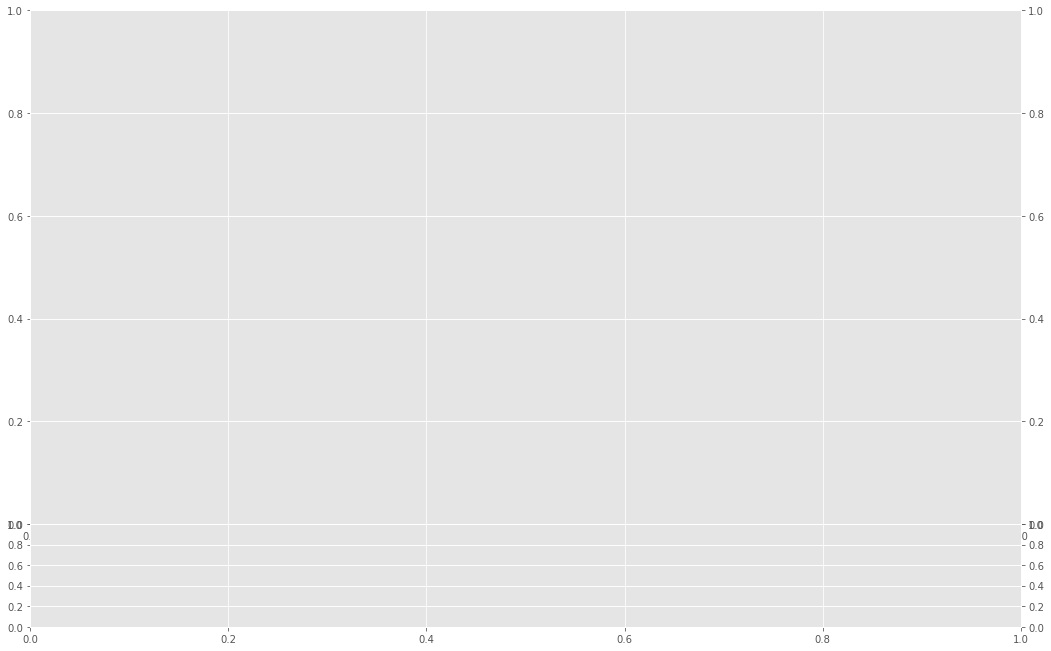

In [37]:
test_env = CustomEnv(test_df, lookback_window_size=lookback_window_size, Show_reward=True, Show_indicators=True)
test_agent(test_env, agent, visualize=False, test_episodes=50, folder="Big", name="2635.74_trader", comment="")